# EDA

In [219]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import logging
logging.getLogger('matplotlib').setLevel(logging.WARNING)
import warnings
warnings.filterwarnings('ignore')

In [220]:
df=pd.read_excel('Datasets/data.xlsx')

Se comienza contando los valores *SD* de las columnas para poder luego cambiarlos por nulos.

In [221]:
df.apply(lambda col: (col == 'SD').sum())

id_hecho            0
cant_victimas       0
fecha               0
hora                0
lugar_del_hecho     0
tipo_de_calle       0
comuna              0
latitud             0
longitud            0
involucrados        0
victima             8
acusado            21
rol                10
sexo                4
edad               51
dtype: int64

Se procede a reemplazar los valores *SD* por nulos y se continua con el análisis de los mismos.

In [222]:
df = df.replace('SD', np.nan)

In [223]:
df.isnull().sum()

id_hecho            0
cant_victimas       0
fecha               0
hora                1
lugar_del_hecho     0
tipo_de_calle       0
comuna              0
latitud            11
longitud           11
involucrados        0
victima             8
acusado            21
rol                10
sexo                4
edad               51
dtype: int64

## Análisis de valores faltantes 

### hora

In [224]:
df[df['hora'].isnull()]

,id_hecho,cant_victimas,fecha,hora,lugar_del_hecho,tipo_de_calle,comuna,latitud,longitud,involucrados,victima,acusado,rol,sexo,edad
534,2019-0103,1,2019-12-18,NaT,"PAZ, GRAL. AV. Y GRIVEO",GRAL PAZ,11,-58.521694,-34.594716,MOTO-MOTO,MOTO,MOTO,CONDUCTOR,MASCULINO,24.0


In [225]:
df['hora'].dt.hour.describe()

count    714.000000
mean      11.558824
std        6.688001
min        0.000000
25%        6.000000
50%       11.000000
75%       17.000000
max       23.000000
Name: hora, dtype: float64

Debido a que la mediana y la media son muy parecidas se puede imputar el valor faltante mediante cualquiera de los dos valores de tendencia central. En este caso se utiliza la media.

In [226]:
#Se crean nuevos dataframe para verificar visualmente 
df_hora_media = df.copy()

#Se obtiene la media y la mediana
media=df['hora'].dt.hour.mean()

# Asume que 'media' es tu hora media como un float
media_hours = int(media)
media_minutes = (media - media_hours) * 60

# Crea un objeto datetime para la fecha base
base = datetime.datetime(2000, 1, 1)

# Añade la media como una timedelta
media_dt = base + datetime.timedelta(hours=media_hours, minutes=media_minutes)

#Reemplazo la hora media en los valores nulos
df_hora_media['hora'] = df_hora_media['hora'].fillna(media_dt)


In [227]:
df_hora_media['hora'].dt.hour.describe()

count    715.000000
mean      11.558042
std        6.683348
min        0.000000
25%        6.000000
50%       11.000000
75%       17.000000
max       23.000000
Name: hora, dtype: float64

In [228]:
media_dt 

datetime.datetime(2000, 1, 1, 11, 33, 31, 764706)

In [229]:
df['hora'].dt.hour.describe()

count    714.000000
mean      11.558824
std        6.688001
min        0.000000
25%        6.000000
50%       11.000000
75%       17.000000
max       23.000000
Name: hora, dtype: float64

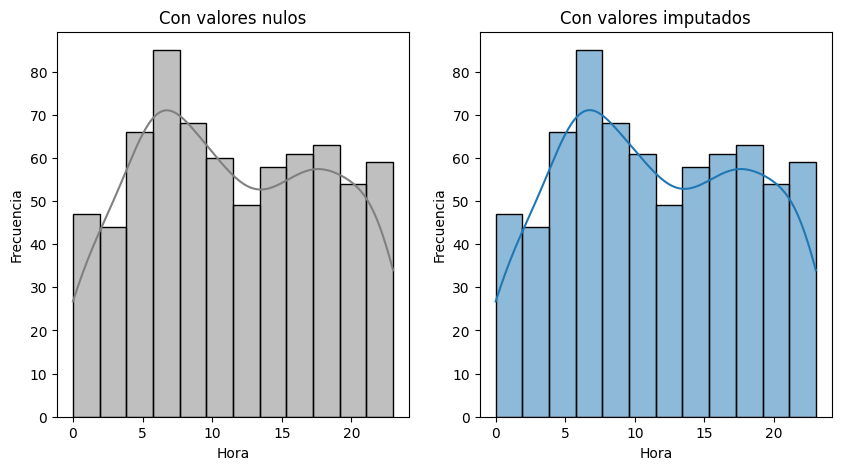

In [230]:
fig, ax= plt.subplots(1,2, figsize=(10,5))

sns.histplot(data=df,x=df['hora'].dt.hour, bins=12,kde=True,ax=ax[0],color='gray')
ax[0].set_title('Con valores nulos')
ax[0].set_xlabel('Hora')
ax[0].set_ylabel('Frecuencia')

sns.histplot(data=df_hora_media,x=df_hora_media['hora'].dt.hour, bins=12,kde=True,ax=ax[1])
ax[1].set_title('Con valores imputados')
ax[1].set_xlabel('Hora')
ax[1].set_ylabel('Frecuencia')
plt.show()


Es importante observar como además de al imputar los valores faltantes la distribución de los datos *hora* no cambia, se puede reconocer un patrón donde se aprecia en que horarios hay mayor cantidad de siniestros.

<Axes: xlabel='hora', ylabel='Count'>

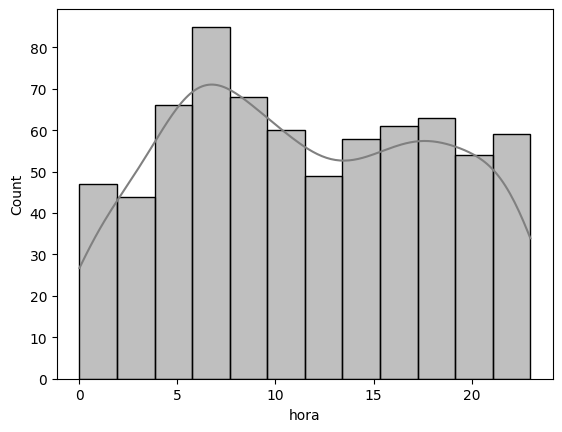

In [231]:
sns.histplot(data=df,x=df['hora'].dt.hour, bins=12,kde=True,color='gray')

### INSIGHT
La mayoría de los accidentes se dan en la franja horaria comprendidad aproximadamente entre las 5:00 y las 12:00 horas. Sin embargo hay otra franja horaria que no hay que descartar que es entre las 15:00 y las 20:00 horas.

In [232]:
#Modifico el dataframe df con los valores imputados
df = df_hora_media.copy()

### Victima

In [233]:
proporcion_nulos=df['victima'].isnull().sum()*100/len(df['victima'])
print('Proporción de nulos en la columna victima:',round(proporcion_nulos,2),'%')

Proporción de nulos en la columna victima: 1.12 %


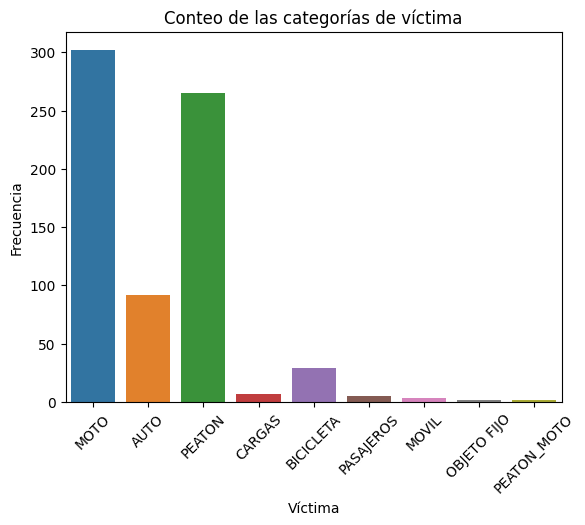

In [234]:
ax=sns.countplot(data=df,x=df['victima'], hue=df['victima'],legend=False)
plt.xticks(fontsize=10, rotation=45);
ax.set_title('Conteo de las categorías de víctima')
ax.set_xlabel('Víctima')
ax.set_ylabel('Frecuencia');

In [235]:
conteo_victimas=df['victima'].value_counts()

In [236]:
print('Conteo de las categorías de víctima:')
for victima in conteo_victimas.index:
    print(victima,':',round(conteo_victimas[victima]*100/conteo_victimas.sum(),2),'%')

Conteo de las categorías de víctima:
MOTO : 42.72 %
PEATON : 37.48 %
AUTO : 13.01 %
BICICLETA : 4.1 %
CARGAS : 0.99 %
PASAJEROS : 0.71 %
MOVIL : 0.42 %
OBJETO FIJO : 0.28 %
PEATON_MOTO : 0.28 %


Al ver los datos nulos estos representan un poco más deñ 1% de los mismos y es una de las categorías con mayor importancia con respecto al objetivo del análisis. Por lo que se decide eliminar las filas que no contengan los datos de las víctimas. Ya que al imputar cualquier valor no tendría ningun sentido debido a la gran diferencia entre las categorias dominantes (*MOTO* y *PEATON*) y el resto.

In [237]:
df.dropna(subset=['victima'],inplace=True)

### INSIGHT
Se observa como la gran cantidad de víctimas son personas que utilizan motos y peatones, estas dos categorías suman poco mas del 77% de las víctimas, por lo que son 2 categorías de suma importancia.

### Acusado

In [258]:
df.isnull().sum()

id_hecho            0
cant_victimas       0
fecha               0
hora                0
lugar_del_hecho     0
tipo_de_calle       0
comuna              0
latitud            11
longitud           11
involucrados        0
victima             0
acusado            17
rol                 3
sexo                3
edad               48
dtype: int64

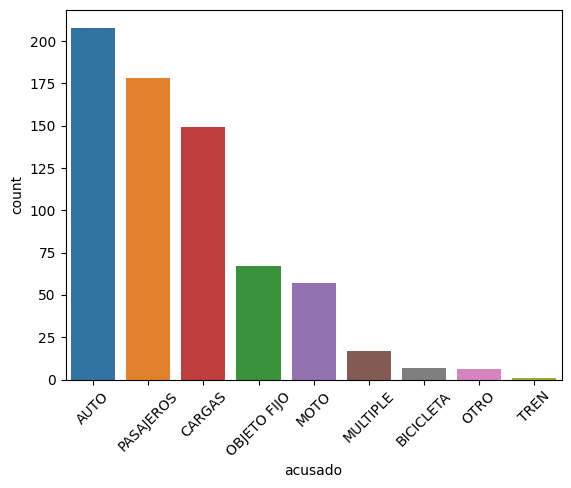

In [238]:
order = df['acusado'].value_counts().index
sns.countplot(data=df,x=df['acusado'], hue=df['acusado'],legend=False, order=order)
plt.xticks(fontsize=10, rotation=45);

A la hora de imputar valores faltantes en la categoría *acusado* buscaremos un patrón que nos permite ver que imputar en base a otra variable.

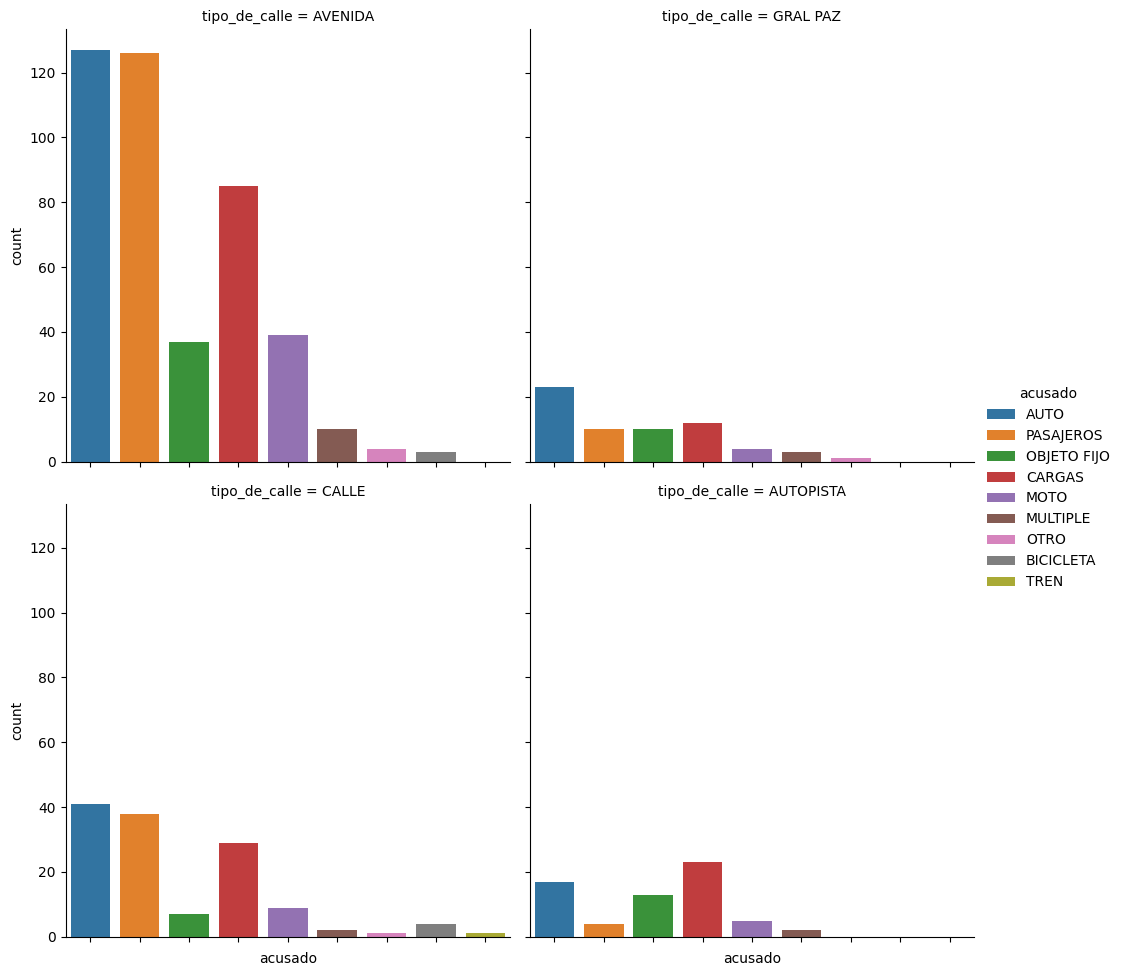

In [239]:
g=sns.catplot(data=df,x='acusado',hue='acusado',kind='count',col='tipo_de_calle',col_wrap=2)

for ax in g.axes.flatten():
    for label in ax.get_xticklabels():
        label.set_visible(True)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=10, rotation=45)

Al explorar la cantidad de victimas por tipo de calle, no encontramos un patron definido pues generalmente la mayoria de los acusados en 3 de los 4 tipos de calle es la categoría *auto*.

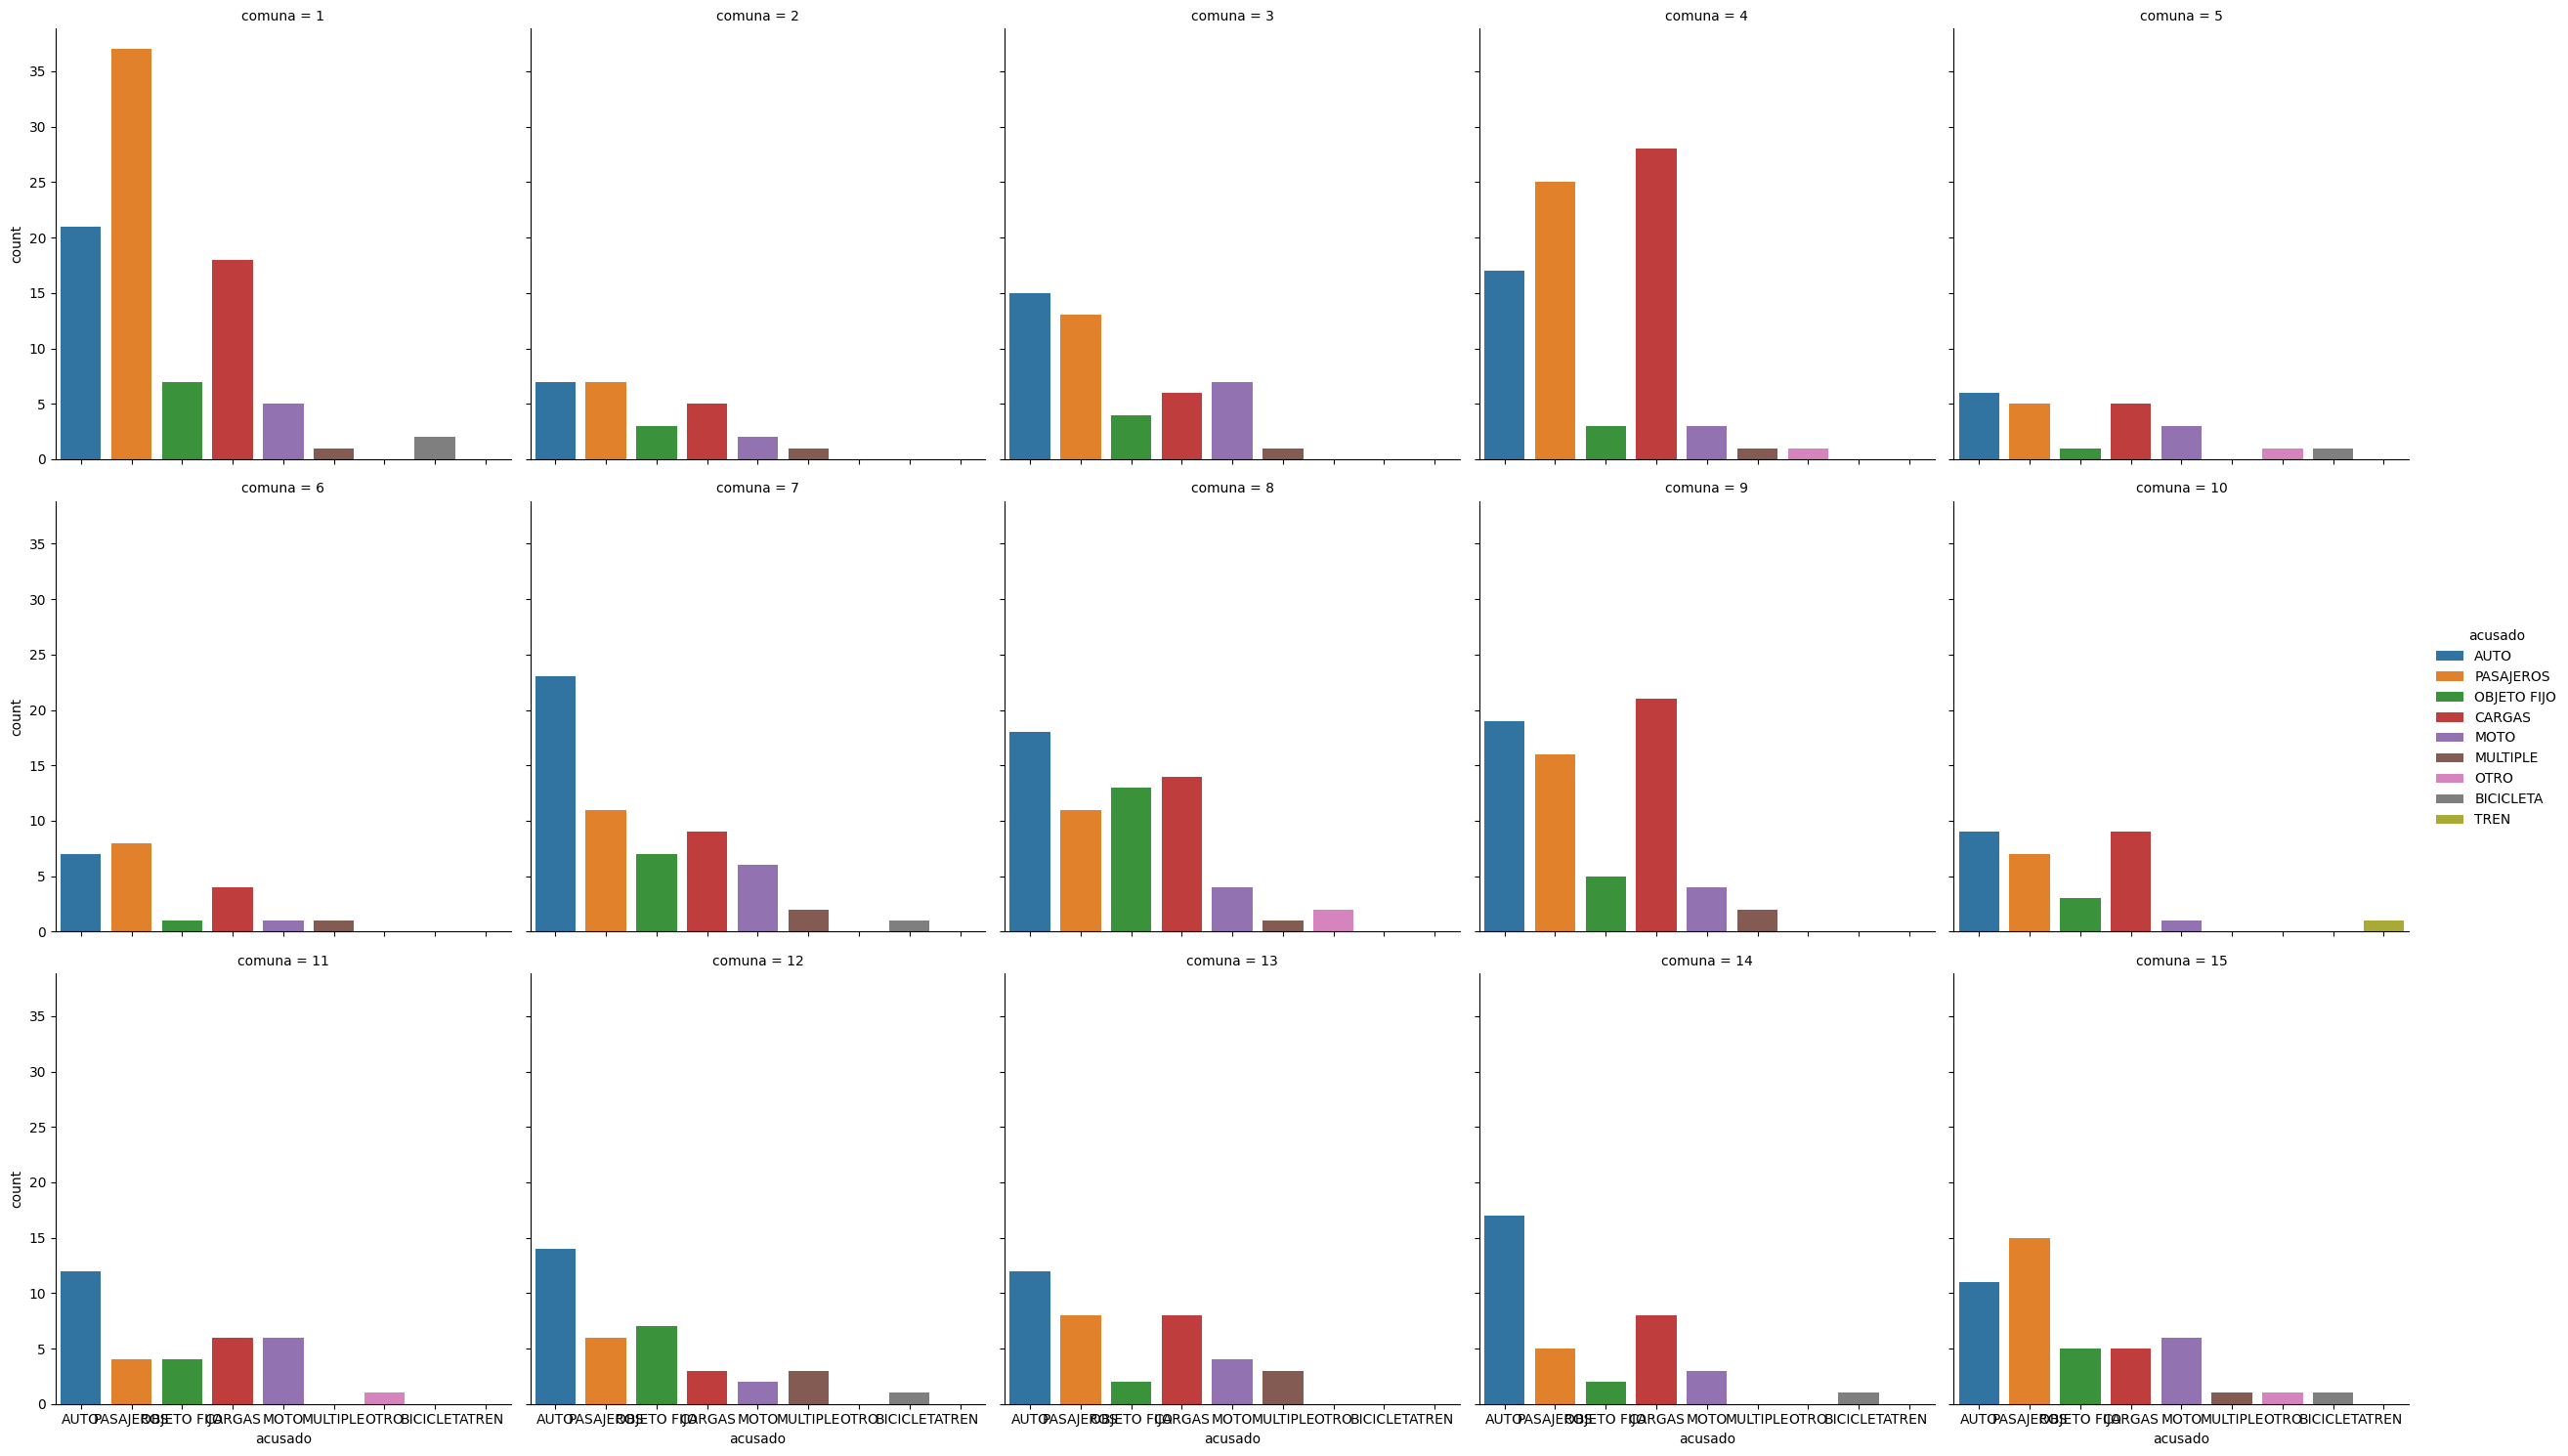

In [240]:
sns.catplot(data=df,x='acusado',hue='acusado',kind='count',col='comuna',col_wrap=5)

for ax in g.axes.flatten():
    for label in ax.get_xticklabels():
        label.set_visible(True)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=10, rotation=45)

Aqui si se puede ver una mayor diferencia entre las comunas donde si bien la mayoria el principal acusado es *AUTO* tambien hay comunas donde categorías como *PASAJEROS* o *CARGAS* tienen mayor cantidad en los conteos.

In [241]:
maximos=df.groupby('comuna')['acusado'].value_counts()
maximos

comuna  acusado    
1       PASAJEROS      37
        AUTO           21
        CARGAS         18
        OBJETO FIJO     7
        MOTO            5
                       ..
15      OBJETO FIJO     5
        CARGAS          5
        OTRO            1
        MULTIPLE        1
        BICICLETA       1
Name: count, Length: 98, dtype: int64

In [242]:
maximos[1].max()

37

In [304]:
data=dict()
for i in range(1,16):
    data[i]=maximos[i].idxmax()
data=pd.Series(data)

In [302]:
maximos[3].idxmax()

'AUTO'

In [245]:
df[df['acusado'].isnull()]

,id_hecho,cant_victimas,fecha,hora,lugar_del_hecho,tipo_de_calle,comuna,latitud,longitud,involucrados,victima,acusado,rol,sexo,edad
3,2016-0004,1,2016-01-10,1900-01-01 00:00:00,AV LARRAZABAL Y GRAL VILLEGAS CONRADO,AVENIDA,8,-58.465039,-34.680930,MOTO-SD,MOTO,NaN,CONDUCTOR,MASCULINO,18.0
33,2016-0045,1,2016-04-11,1900-01-01 10:25:00,AV GRAL PAZ Y AV DEL LIBERTADOR,GRAL PAZ,13,-58.467435,-34.534769,MOTO-SD,MOTO,NaN,CONDUCTOR,MASCULINO,NaN
39,2016-0052,1,2016-04-20,1900-01-01 20:00:00,AUTOPISTA LUGONES PK 10000,AUTOPISTA,13,NaN,NaN,MOTO-SD,MOTO,NaN,NaN,NaN,NaN
58,2016-0080,1,2016-06-18,1900-01-01 06:42:00,AV GRAL PAZ Y AV RIVADAVIA,GRAL PAZ,9,-58.529280,-34.639318,AUTO-SD,AUTO,NaN,CONDUCTOR,MASCULINO,60.0
84,2016-0110,1,2016-08-24,1900-01-01 20:21:00,AV ALBERDI Y CARHUE,AVENIDA,9,-58.512322,-34.659035,PEATON-SD,PEATON,NaN,PEATON,MASCULINO,57.0
107,2016-0135,1,2016-10-24,1900-01-01 05:00:00,AV FIGUEROA ALCORTA Y PINEDO,AVENIDA,14,-58.422602,-34.564037,PEATON-SD,PEATON,NaN,PEATON,MASCULINO,29.0
114,2016-0143,1,2016-11-06,1900-01-01 04:41:00,AV 27 DE FEBRERO Y AV ESCALADA,AVENIDA,8,-58.444513,-34.684759,MOTO-SD,MOTO,NaN,CONDUCTOR,MASCULINO,35.0
127,2016-0159,1,2016-12-04,1900-01-01 07:21:00,AV 27 DE FEBRERO Y AV ESCALADA,AVENIDA,8,-58.444513,-34.684759,AUTO-SD,AUTO,NaN,CONDUCTOR,MASCULINO,23.0
160,2017-0025,1,2017-02-24,1900-01-01 17:05:00,AV. FERNANDEZ DE LA CRUZ Y RIVERA INDARTE,AVENIDA,7,-58.436144,-34.654246,MOTO-SD,MOTO,NaN,CONDUCTOR,MASCULINO,23.0
202,2017-0069,1,2017-05-24,1900-01-01 14:15:00,AV. GRAL. PAZ Y ULRICO SCHMIDL,GRAL PAZ,9,-58.521731,-34.659975,MOTO-SD,MOTO,NaN,CONDUCTOR,MASCULINO,39.0


In [313]:
prueba=df.copy()

In [314]:
prueba['acusado']=prueba['acusado'].fillna(data[prueba['comuna']])

ValueError: cannot reindex on an axis with duplicate labels

In [316]:
data_mean = df.groupby('comuna').max()

TypeError: agg function failed [how->max,dtype->object]

In [187]:
df[df['id_hecho']=='2016-0004']

,id_hecho,cant_victimas,fecha,hora,lugar_del_hecho,tipo_de_calle,comuna,latitud,longitud,involucrados,victima,acusado,rol,sexo,edad
3,2016-0004,1,2016-01-10,1900-01-01,AV LARRAZABAL Y GRAL VILLEGAS CONRADO,AVENIDA,8,-58.465039,-34.68093,MOTO-SD,MOTO,18,CONDUCTOR,MASCULINO,18.0


In [128]:
df.isnull().sum()

id_hecho            0
cant_victimas       0
fecha               0
hora                0
lugar_del_hecho     0
tipo_de_calle       0
comuna              0
latitud            10
longitud           10
involucrados        0
victima             0
acusado            16
rol                 2
sexo                2
edad               47
dtype: int64

### Latitud y Longitud

In [82]:
df[df['latitud'].isnull()]

,id_hecho,cant_victimas,fecha,hora,lugar_del_hecho,tipo_de_calle,comuna,latitud,longitud,involucrados,victima,acusado,rol,sexo,edad
39,2016-0052,1,2016-04-20,1900-01-01 20:00:00,AUTOPISTA LUGONES PK 10000,AUTOPISTA,13,NaN,NaN,MOTO-SD,MOTO,NaN,NaN,NaN,NaN
108,2016-0136,1,2016-10-25,1900-01-01 00:00:00,AU BUENOS AIRES - LA PLATA KM. 4,AUTOPISTA,4,NaN,NaN,MOTO-CARGAS,MOTO,CARGAS,CONDUCTOR,NaN,NaN
180,2017-0042,1,2017-04-10,1900-01-01 09:00:00,AV. LEOPOLDO LUGONES PKM 6900,GRAL PAZ,14,NaN,NaN,MOTO-CARGAS,MOTO,CARGAS,CONDUCTOR,MASCULINO,NaN
184,2017-0050,2,2017-04-28,1900-01-01 11:08:08,AU PERITO MORENO Y RAMAL ENLACE AU1/AU6,AUTOPISTA,9,NaN,NaN,MOTO-CARGAS,MOTO,CARGAS,CONDUCTOR,MASCULINO,46.0
185,2017-0050,2,2017-04-28,1900-01-01 11:08:08,AU PERITO MORENO Y RAMAL ENLACE AU1/AU6,AUTOPISTA,9,NaN,NaN,MOTO-CARGAS,MOTO,CARGAS,PASAJERO_ACOMPAÑANTE,MASCULINO,16.0
186,2017-0051,1,2017-05-01,1900-01-01 03:47:47,AU DELLEPIANE 2400,AUTOPISTA,7,NaN,NaN,AUTO-AUTO,AUTO,AUTO,CONDUCTOR,MASCULINO,33.0
264,2017-0140,1,2017-11-19,1900-01-01 23:22:17,AU ARTURO FRONDIZI PKM 3100,AUTOPISTA,4,NaN,NaN,MOTO-PASAJEROS,MOTO,PASAJEROS,CONDUCTOR,MASCULINO,24.0
325,2018-0039,1,2018-04-21,1900-01-01 22:15:00,AUTOPISTA LUGONES KM 4.7,AUTOPISTA,14,NaN,NaN,PEATON-AUTO,PEATON,AUTO,PEATON,MASCULINO,37.0
562,2020-0026,1,2020-05-17,1900-01-01 06:40:00,"LUGONES, LEOPOLDO AV. KM 6,1",AUTOPISTA,14,NaN,NaN,MOTO-OBJETO FIJO,MOTO,OBJETO FIJO,CONDUCTOR,MASCULINO,28.0
576,2020-0039,1,2020-09-01,1900-01-01 19:17:42,MURGUIONDO 2700,CALLE,9,NaN,NaN,PEATON-CARGAS,PEATON,CARGAS,PEATON,MASCULINO,44.0


Se elimina la primera fila debido a que tiene demasiados valores nulos

In [89]:
df=df[df['id_hecho']!='2016-0052']

In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 714 entries, 0 to 714
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   id_hecho         714 non-null    object        
 1   cant_victimas    714 non-null    int64         
 2   fecha            714 non-null    datetime64[ns]
 3   hora             714 non-null    datetime64[ns]
 4   lugar_del_hecho  714 non-null    object        
 5   tipo_de_calle    714 non-null    object        
 6   comuna           714 non-null    int64         
 7   latitud          704 non-null    float64       
 8   longitud         704 non-null    float64       
 9   involucrados     714 non-null    object        
 10  victima          706 non-null    object        
 11  acusado          694 non-null    object        
 12  rol              705 non-null    object        
 13  sexo             711 non-null    object        
 14  edad             664 non-null    float64       

## Cantidad de víctimas

En primer lugar se examinan las variables cuanlitativas y las cuantitativas discretas con los gráficos de conteos de frecuencias.

In [215]:
df['cant_victimas'].value_counts()

cant_victimas
1    674
2     38
3      3
Name: count, dtype: int64

Text(0, 0.5, 'Frecuencia')

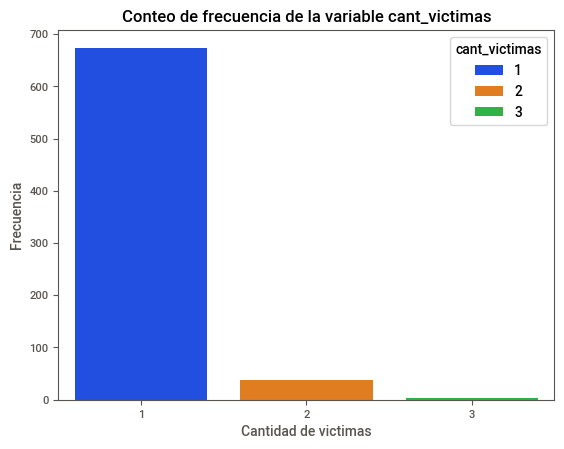

In [216]:
ax=sns.countplot(data=df, x='cant_victimas', hue='cant_victimas', palette='bright')
ax.set_title('Conteo de frecuencia de la variable cant_victimas')
ax.set_xlabel('Cantidad de victimas')
ax.set_ylabel('Frecuencia')

In [217]:
#Porcentaje de cantidad de victimas
df['cant_victimas'].value_counts()/df['cant_victimas'].count()*100

cant_victimas
1    94.265734
2     5.314685
3     0.419580
Name: count, dtype: float64

Vemos como en el 92.27% de siniestros la cantidad de víctimas es una persona

Con el tipo de variable *datetime* se puede analizar mas fácilmente las fechas y los periodos típicos.

Text(0, 0.5, 'Frecuencia')

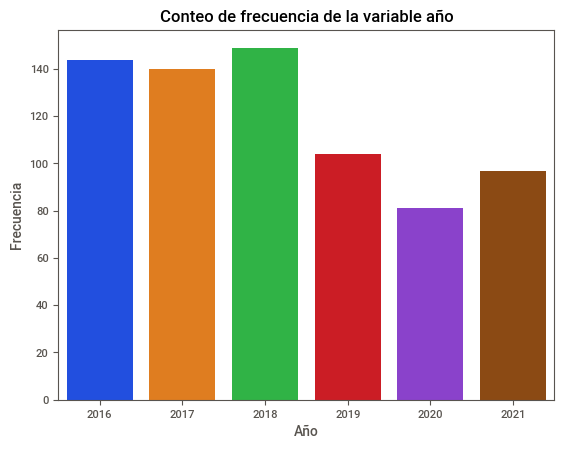

In [218]:
ax=sns.countplot(data=df, x=df['fecha'].dt.year, hue=df['fecha'].dt.year, palette='bright',legend=False)
ax.set_title('Conteo de frecuencia de la variable año')
ax.set_xlabel('Año')
ax.set_ylabel('Frecuencia')


In [ ]:
fig, ax1 = plt.subplots()
sns.countplot(data=df, x=df['fecha'].dt.year, hue=df['fecha'].dt.year, palette='bright',legend=False)
ax2 = ax1.twinx()

Se puede ver una tendencia en la disminución de las víctimas por siniestros desde el 2016 al 2021

In [219]:
#Creo la columna semestre
df['semestre'] = (df['fecha'].dt.month - 1) // 6 + 1

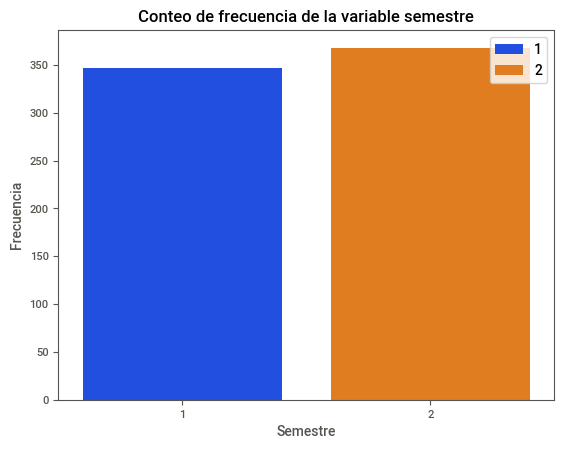

In [220]:
ax=sns.countplot(data=df, x='semestre', hue='semestre', palette='bright')
ax.set_title('Conteo de frecuencia de la variable semestre')
ax.set_xlabel('Semestre')
ax.set_ylabel('Frecuencia')
ax.legend(loc='best')

In [221]:
#Creo la columna trimestre
df['trimestre']=df['fecha'].dt.quarter

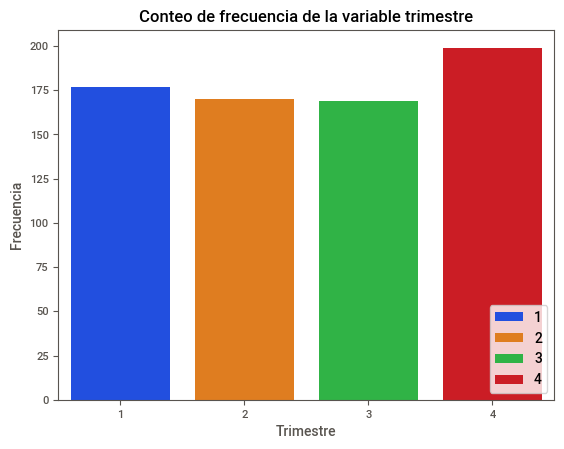

In [222]:
ax=sns.countplot(data=df, x='trimestre', hue='trimestre', palette='bright')
ax.set_title('Conteo de frecuencia de la variable trimestre')
ax.set_xlabel('Trimestre')
ax.set_ylabel('Frecuencia')
ax.legend(loc='lower right')

En cuanto a los trimestres, el último del año presenta la mayor cantidad de victimas a lo largo de los años de los que se cuentan con datos.

In [223]:
df['bimestre'] = ((df['fecha'].dt.month - 1) // 2) + 1

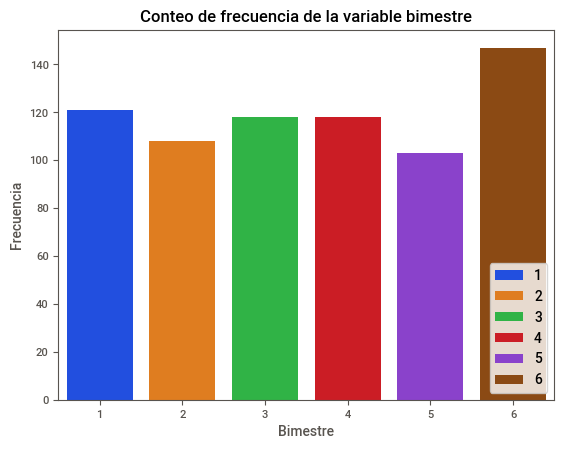

In [224]:
ax=sns.countplot(data=df, x='bimestre', hue='bimestre', palette='bright')
ax.set_title('Conteo de frecuencia de la variable bimestre')
ax.set_xlabel('Bimestre')
ax.set_ylabel('Frecuencia')
ax.legend(loc='lower right')

Incluso podríamos decir que la mayor cantidad de víctimas se dan el último bimestre

Text(0, 0.5, 'Frecuencia')

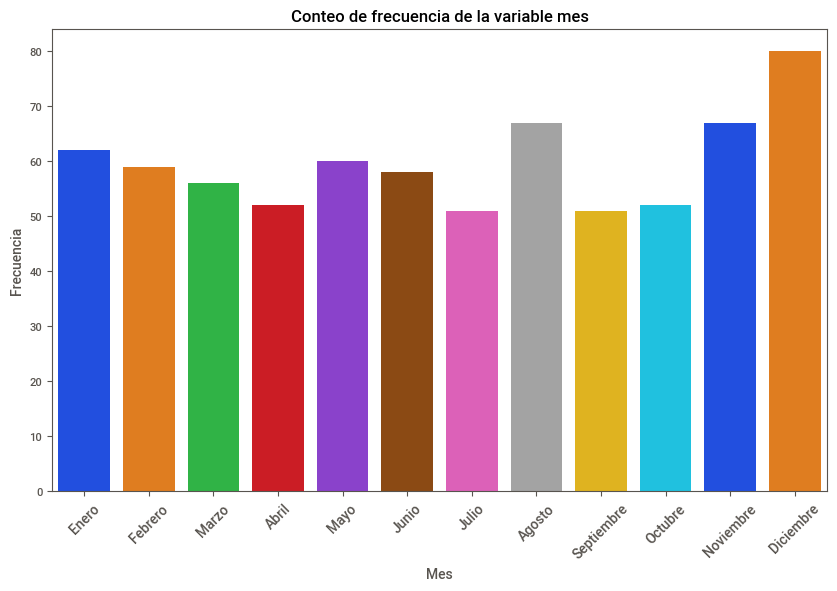

In [225]:
plt.figure(figsize=(10, 6))
ax=sns.countplot(data=df,x=df['fecha'].dt.month_name(locale='es'),hue=df['fecha'].dt.month_name('es'),palette='bright')
plt.xticks(fontsize=10, rotation=45)
ax.set_title('Conteo de frecuencia de la variable mes')
ax.set_xlabel('Mes')
ax.set_ylabel('Frecuencia')

Text(0, 0.5, 'Frecuencia')

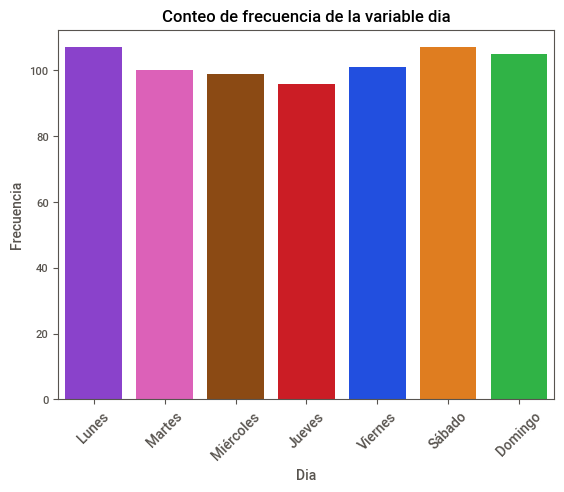

In [226]:
ax=sns.countplot(data=df,x=df['fecha'].dt.day_name(locale='es'),hue=df['fecha'].dt.day_name(locale='es'),palette='bright',order=['Lunes','Martes','Miércoles','Jueves','Viernes','Sábado','Domingo'])
plt.xticks(fontsize=10, rotation=45)
ax.set_title('Conteo de frecuencia de la variable dia')
ax.set_xlabel('Dia')
ax.set_ylabel('Frecuencia')

Text(0, 0.5, 'Frecuencia')

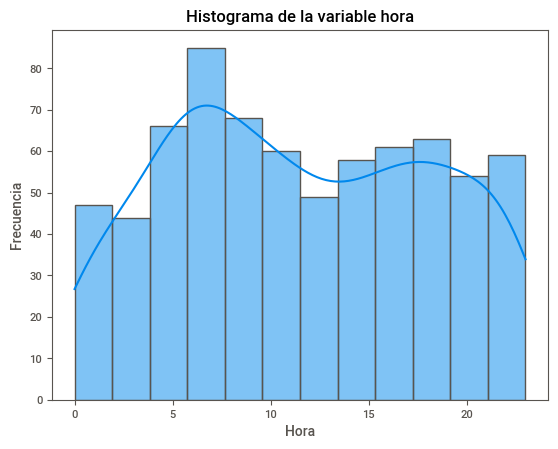

In [227]:
ax=sns.histplot(data=df,x=df['hora'].dt.hour, bins=12,kde=True)
ax.set_title('Histograma de la variable hora')
ax.set_xlabel('Hora')
ax.set_ylabel('Frecuencia')

La mayor cantidad de víctimas se dan entre las 5:00 y las 10:00 de la mañana y entre las 15:00 y las 20:00

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'MOTO'),
  Text(1, 0, 'AUTO'),
  Text(2, 0, 'PEATON'),
  Text(3, 0, 'SD'),
  Text(4, 0, 'CARGAS'),
  Text(5, 0, 'BICICLETA'),
  Text(6, 0, 'PASAJEROS'),
  Text(7, 0, 'MOVIL'),
  Text(8, 0, 'OBJETO FIJO'),
  Text(9, 0, 'PEATON_MOTO')])

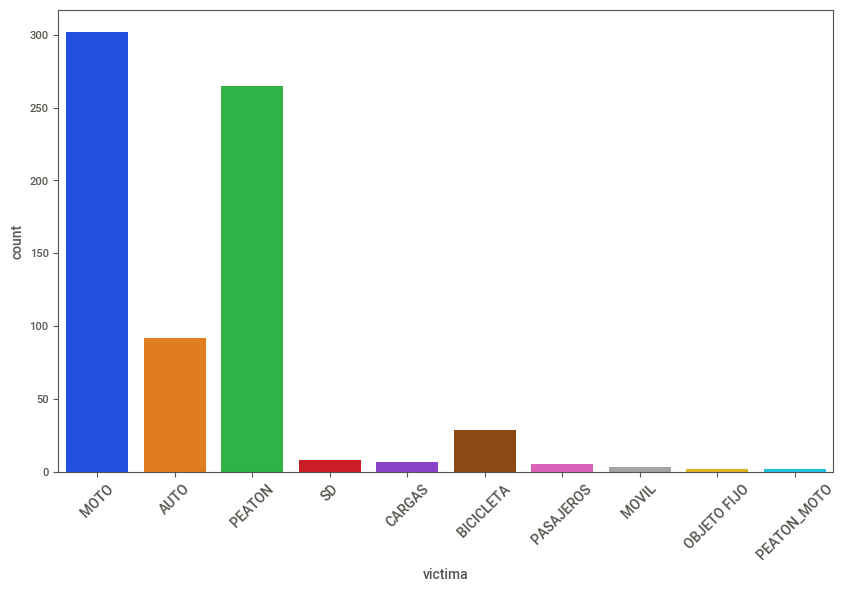

In [228]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='victima', hue='victima', palette='bright')
plt.xticks(fontsize=10, rotation=45)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'AUTO'),
  Text(1, 0, 'PASAJEROS'),
  Text(2, 0, 'SD'),
  Text(3, 0, 'OBJETO FIJO'),
  Text(4, 0, 'CARGAS'),
  Text(5, 0, 'MOTO'),
  Text(6, 0, 'MULTIPLE'),
  Text(7, 0, 'OTRO'),
  Text(8, 0, 'BICICLETA'),
  Text(9, 0, 'TREN')])

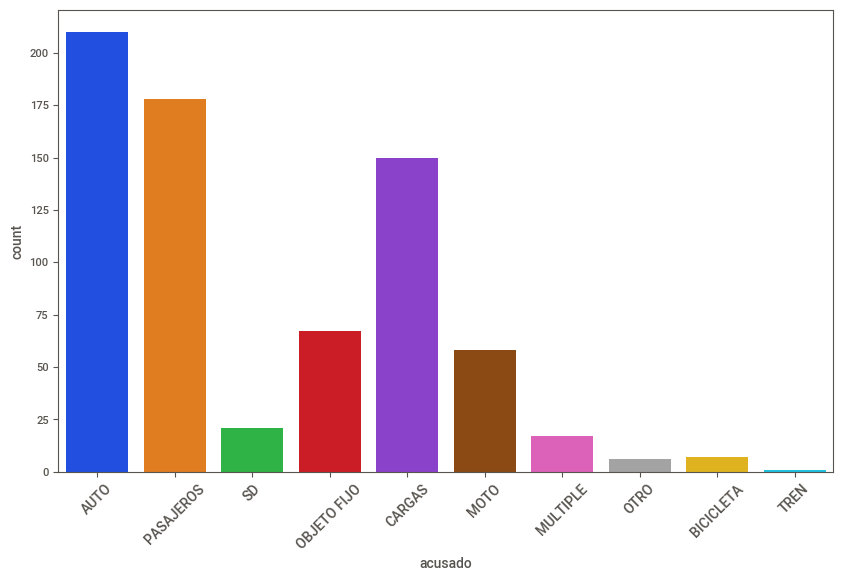

In [229]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='acusado', hue='acusado', palette='bright')
plt.xticks(fontsize=10, rotation=45)

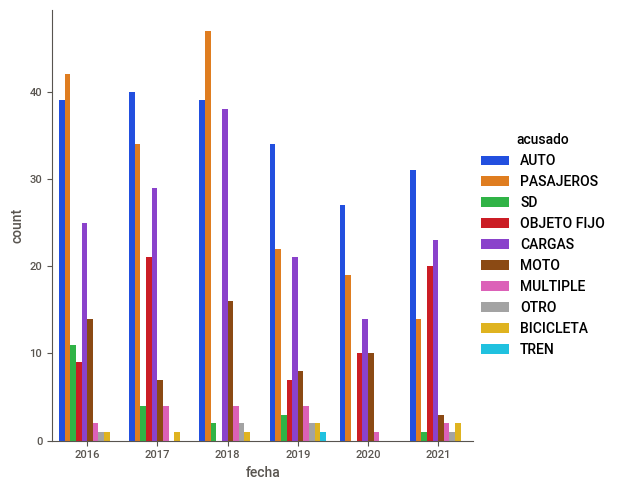

In [230]:
sns.catplot(data=df, x=df['fecha'].dt.year, hue='acusado', kind='count', palette='bright')

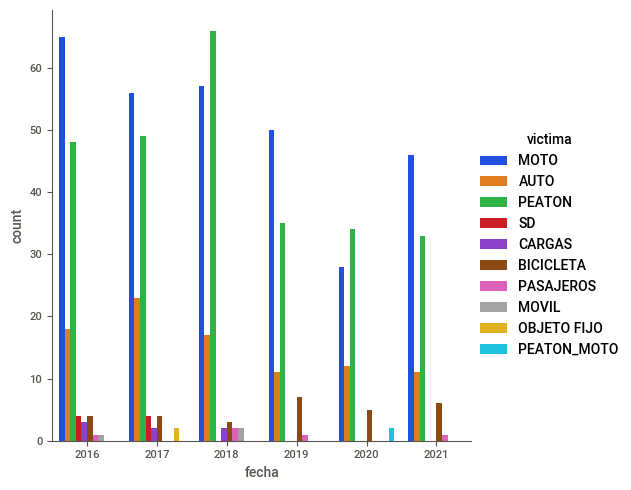

In [231]:
sns.catplot(data=df, x=df['fecha'].dt.year, hue='victima', kind='count', palette='bright')

Text(0, 0.5, 'Frecuencia')

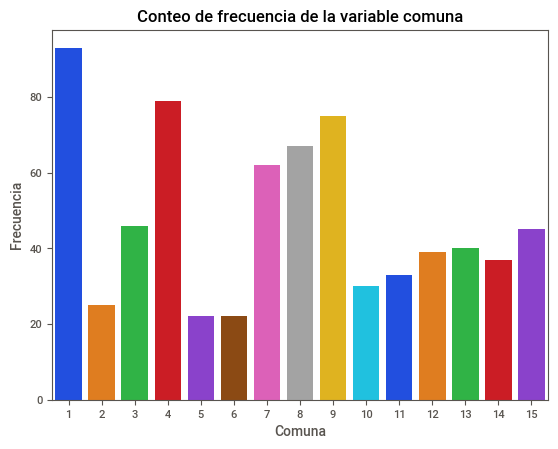

In [232]:
ax=sns.countplot(data=df, x='comuna', hue='comuna', palette='bright',legend=False)
ax.set_title('Conteo de frecuencia de la variable comuna')
ax.set_xlabel('Comuna')
ax.set_ylabel('Frecuencia')


Text(0, 0.5, 'Frecuencia')

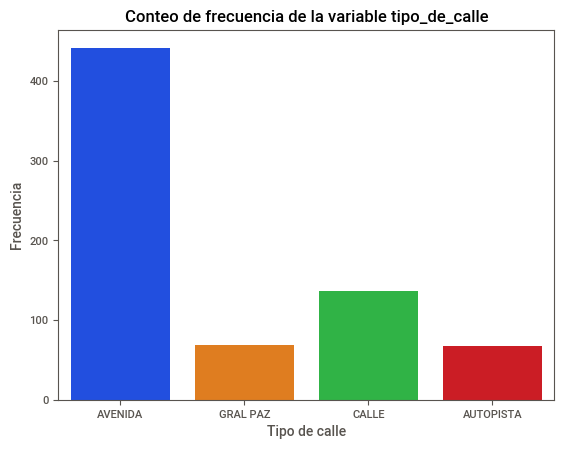

In [233]:
ax=sns.countplot(data=df, x='tipo_de_calle', hue='tipo_de_calle', palette='bright')
ax.set_title('Conteo de frecuencia de la variable tipo_de_calle')
ax.set_xlabel('Tipo de calle')
ax.set_ylabel('Frecuencia')


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'MOTO-AUTO'),
  Text(1, 0, 'MOTO-SD'),
  Text(2, 0, 'MOTO-PASAJEROS'),
  Text(3, 0, 'MOTO-OBJETO FIJO'),
  Text(4, 0, 'MOTO-CARGAS'),
  Text(5, 0, 'MOTO-MOTO'),
  Text(6, 0, 'MULTIPLE'),
  Text(7, 0, 'MOTO-MOVIL'),
  Text(8, 0, 'MOTO-BICICLETA'),
  Text(9, 0, 'MOTO-OTRO')])

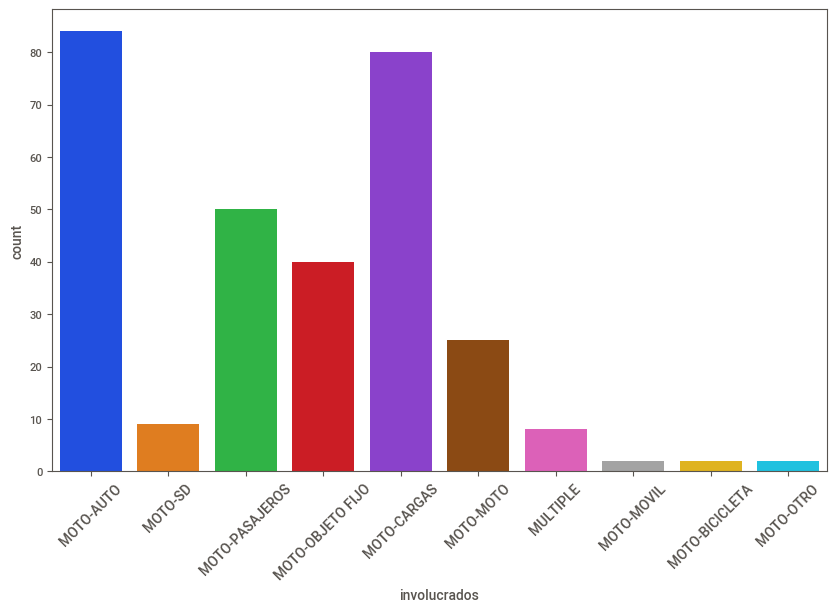

In [234]:
plt.figure(figsize=(10, 6))
ax=sns.countplot(data=df, x=df[df['victima']=='MOTO']['involucrados'], hue=df[df['victima']=='MOTO']['involucrados'], palette='bright')
plt.xticks(fontsize=10, rotation=45)

In [235]:
df['edad'] = df['edad'].replace('SD', np.nan)

Text(0.5, 0, 'Edad')

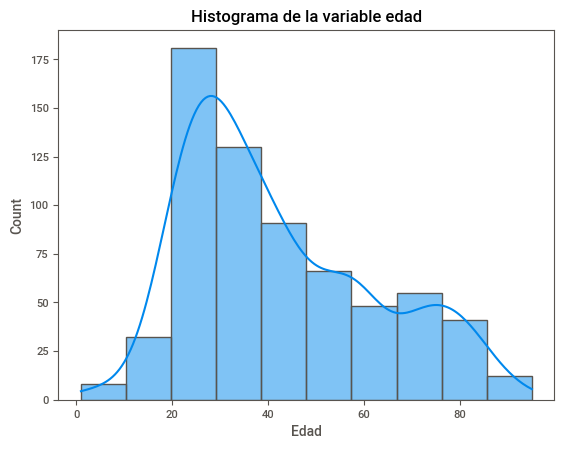

In [243]:
ax=sns.histplot(data=df,x='edad',bins=10,kde=True)
ax.set_title('Histograma de la variable edad')
ax.set_xlabel('Edad')

In [237]:
df['edad'].median()

37.0

In [238]:
df['edad'].mean()

42.16716867469879

In [242]:
df[df['edad']>70]['victima'].value_counts()

victima
PEATON       73
AUTO          8
PASAJEROS     2
MOTO          2
BICICLETA     2
SD            1
Name: count, dtype: int64